# Zipline algorithm analysis example in pyfolio

Here's an example where we run an algorithm with zipline, then produce tear sheets for that algorithm.

## Imports
Import pyfolio, along with the necessary modules for running our zipline backtest.

In [1]:
%matplotlib inline
import pyfolio as pf

In [2]:
import sys
import logbook
import numpy as np
from datetime import datetime
import pytz

from zipline.algorithm import TradingAlgorithm
from zipline.utils.factory import load_from_yahoo
from zipline.finance import commission

## Run our zipline algorithm
This algorithm can also be adjusted to execute a modified, or completely different, trading strategy.

In [3]:
# Zipline trading algorithm
# Taken from zipline.examples.olmar
zipline_logging = logbook.NestedSetup([
    logbook.NullHandler(level=logbook.DEBUG),
    logbook.StreamHandler(sys.stdout, level=logbook.INFO),
    logbook.StreamHandler(sys.stderr, level=logbook.ERROR),
])
zipline_logging.push_application()

STOCKS = ['AMD', 'CERN', 'COST', 'DELL', 'GPS', 'INTC', 'MMM']


# On-Line Portfolio Moving Average Reversion

# More info can be found in the corresponding paper:
# http://icml.cc/2012/papers/168.pdf
def initialize(algo, eps=1, window_length=5):
    algo.stocks = STOCKS
    algo.sids = [algo.symbol(symbol) for symbol in algo.stocks]
    algo.m = len(algo.stocks)
    algo.price = {}
    algo.b_t = np.ones(algo.m) / algo.m
    algo.last_desired_port = np.ones(algo.m) / algo.m
    algo.eps = eps
    algo.init = True
    algo.days = 0
    algo.window_length = window_length

    algo.set_commission(commission.PerShare(cost=0))


def handle_data(algo, data):
    algo.days += 1
    if algo.days < algo.window_length:
        return

    if algo.init:
        rebalance_portfolio(algo, data, algo.b_t)
        algo.init = False
        return

    m = algo.m

    x_tilde = np.zeros(m)
    b = np.zeros(m)

    # find relative moving average price for each asset
    mavgs = data.history(algo.sids, 'price', algo.window_length, '1d').mean()
    for i, sid in enumerate(algo.sids):
        price = data.current(sid, "price")
        # Relative mean deviation
        x_tilde[i] = mavgs[sid] / price

    ###########################
    # Inside of OLMAR (algo 2)
    x_bar = x_tilde.mean()

    # market relative deviation
    mark_rel_dev = x_tilde - x_bar

    # Expected return with current portfolio
    exp_return = np.dot(algo.b_t, x_tilde)
    weight = algo.eps - exp_return
    variability = (np.linalg.norm(mark_rel_dev)) ** 2

    # test for divide-by-zero case
    if variability == 0.0:
        step_size = 0
    else:
        step_size = max(0, weight / variability)

    b = algo.b_t + step_size * mark_rel_dev
    b_norm = simplex_projection(b)
    np.testing.assert_almost_equal(b_norm.sum(), 1)

    rebalance_portfolio(algo, data, b_norm)

    # update portfolio
    algo.b_t = b_norm


def rebalance_portfolio(algo, data, desired_port):
    # rebalance portfolio
    desired_amount = np.zeros_like(desired_port)
    current_amount = np.zeros_like(desired_port)
    prices = np.zeros_like(desired_port)

    if algo.init:
        positions_value = algo.portfolio.starting_cash
    else:
        positions_value = algo.portfolio.positions_value + \
            algo.portfolio.cash

    for i, sid in enumerate(algo.sids):
        current_amount[i] = algo.portfolio.positions[sid].amount
        prices[i] = data.current(sid, "price")

    desired_amount = np.round(desired_port * positions_value / prices)

    algo.last_desired_port = desired_port
    diff_amount = desired_amount - current_amount

    for i, sid in enumerate(algo.sids):
        algo.order(sid, diff_amount[i])


def simplex_projection(v, b=1):
    """Projection vectors to the simplex domain
    Implemented according to the paper: Efficient projections onto the
    l1-ball for learning in high dimensions, John Duchi, et al. ICML 2008.
    Implementation Time: 2011 June 17 by Bin@libin AT pmail.ntu.edu.sg
    Optimization Problem: min_{w}\| w - v \|_{2}^{2}
    s.t. sum_{i=1}^{m}=z, w_{i}\geq 0
    Input: A vector v \in R^{m}, and a scalar z > 0 (default=1)
    Output: Projection vector w
    :Example:
    >>> proj = simplex_projection([.4 ,.3, -.4, .5])
    >>> print(proj)
    array([ 0.33333333, 0.23333333, 0. , 0.43333333])
    >>> print(proj.sum())
    1.0
    Original matlab implementation: John Duchi (jduchi@cs.berkeley.edu)
    Python-port: Copyright 2013 by Thomas Wiecki (thomas.wiecki@gmail.com).
    """

    v = np.asarray(v)
    p = len(v)

    # Sort v into u in descending order
    v = (v > 0) * v
    u = np.sort(v)[::-1]
    sv = np.cumsum(u)

    rho = np.where(u > (sv - b) / np.arange(1, p + 1))[0][-1]
    theta = np.max([0, (sv[rho] - b) / (rho + 1)])
    w = (v - theta)
    w[w < 0] = 0
    return w


start = datetime(2004, 1, 1, 0, 0, 0, 0, pytz.utc)
end = datetime(2010, 1, 1, 0, 0, 0, 0, pytz.utc)

# Load price data from yahoo.
data = load_from_yahoo(stocks=STOCKS, indexes={}, start=start, end=end)
data = data.dropna()

# Create and run the algorithm.
olmar = TradingAlgorithm(handle_data=handle_data, initialize=initialize)
results = olmar.run(data)

[2016-04-21 09:37:33.915336] INFO: Loader: Loading stock: AMD
[2016-04-21 09:37:33.926626] INFO: Loader: Loading stock: CERN
[2016-04-21 09:37:33.936490] INFO: Loader: Loading stock: COST
[2016-04-21 09:37:33.951613] INFO: Loader: Loading stock: DELL
[2016-04-21 09:37:33.965023] INFO: Loader: Loading stock: GPS
[2016-04-21 09:37:33.976631] INFO: Loader: Loading stock: INTC
[2016-04-21 09:37:33.987218] INFO: Loader: Loading stock: MMM
[2016-04-21 09:37:50.955240] INFO: Performance: Simulated 1511 trading days out of 1511.
[2016-04-21 09:37:50.956092] INFO: Performance: first open: 2004-01-02 14:31:00+00:00
[2016-04-21 09:37:50.956915] INFO: Performance: last close: 2009-12-31 21:00:00+00:00


## Extract metrics
Get the returns, positions, and transactions from the zipline backtest object.

In [4]:
returns, positions, transactions, gross_lev = pf.utils.extract_rets_pos_txn_from_zipline(results)

## Single plot example
Make one plot of the top 5 drawdown periods.

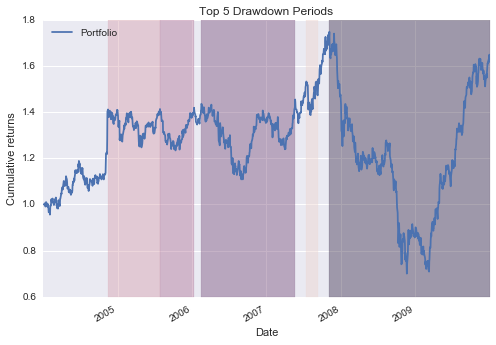

In [5]:
pf.plot_drawdown_periods(returns, top=5).set_xlabel('Date')

## Full tear sheet example
Create a full tear sheet for our algorithm. As an example, set the live start date to something arbitrary.

Entire data start date: 2004-01-02
Entire data end date: 2009-12-31


Out-of-Sample Months: 2
Backtest Months: 69


Performance statistics,All history,Backtest,Out of sample
annual_return,0.08,0.08,0.03
annual_volatility,0.25,0.26,0.22
sharpe_ratio,0.44,0.43,0.25
calmar_ratio,0.14,0.14,0.42
stability_of_timeseries,-0.01,-0.09,0.22
max_drawdown,-0.60,-0.60,-0.07
omega_ratio,1.08,1.08,1.04
sortino_ratio,0.65,0.64,0.34
skew,0.27,0.28,-0.28
kurtosis,4.05,4.10,0.47


Worst Drawdown Periods,net drawdown in %,peak date,valley date,recovery date,duration
0,59.91,2007-11-06,2008-11-20,NaT,NaN
1,22.79,2006-02-16,2006-08-31,2007-05-22,329
2,12.70,2005-07-28,2005-10-12,2006-01-11,120
3,11.65,2004-11-15,2005-04-28,2005-07-28,184
4,9.50,2007-07-16,2007-08-06,2007-09-13,44




[-0.032 -0.069]


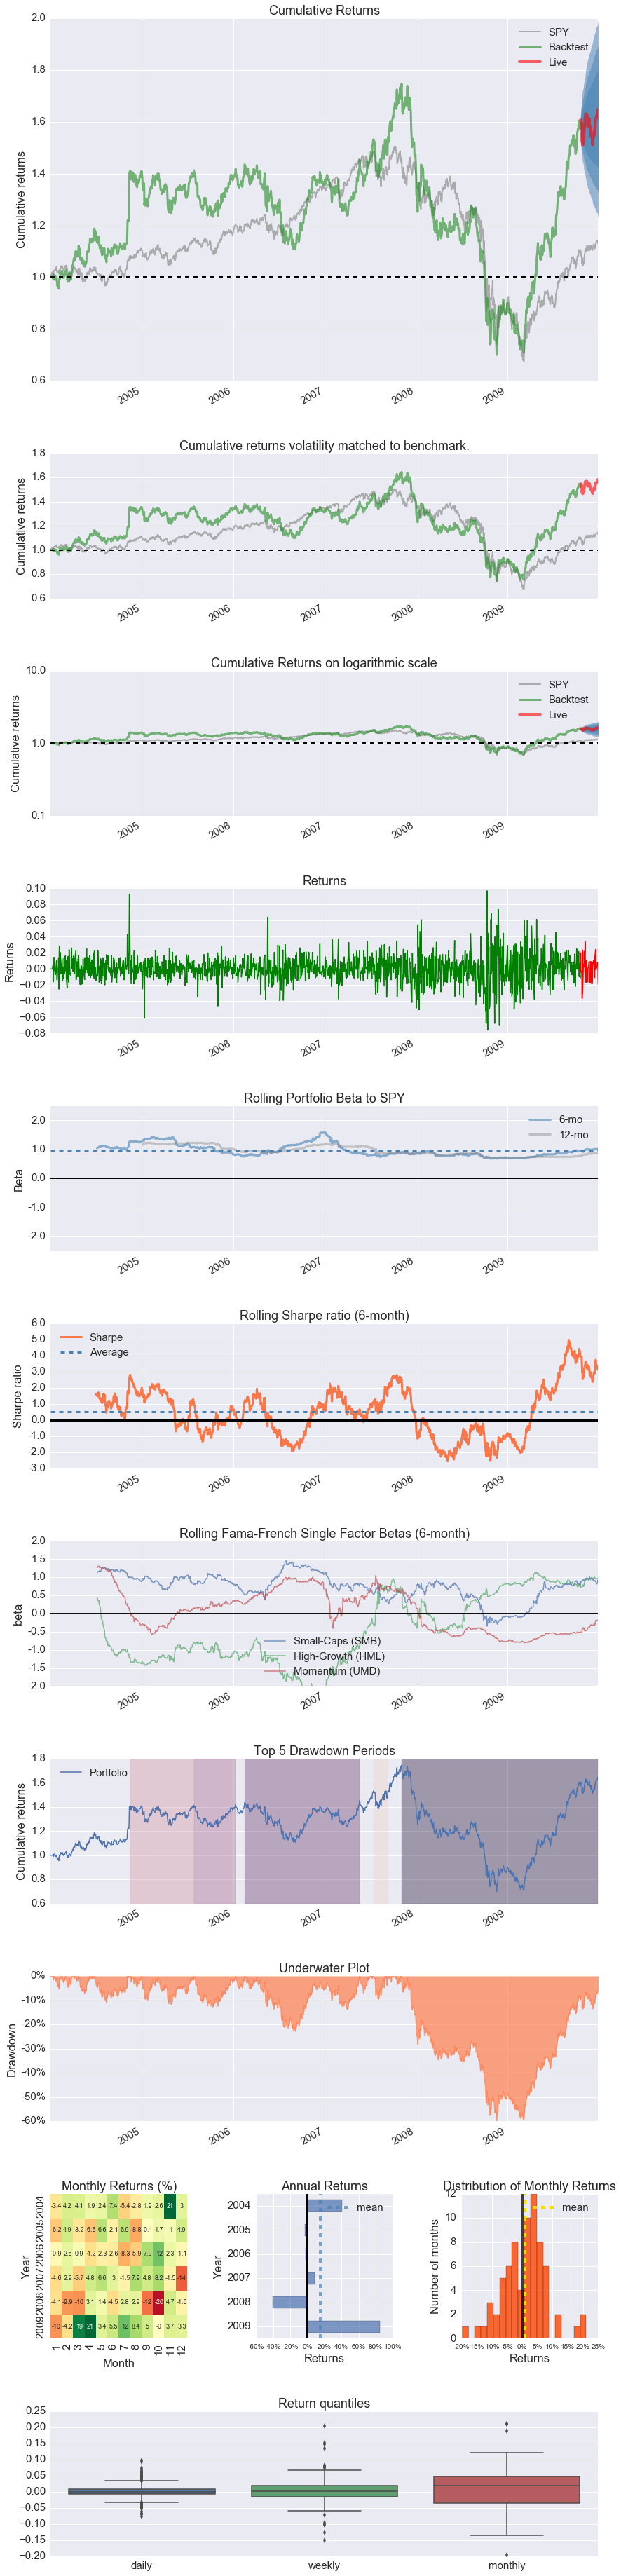

Stress Events,mean,min,max
Lehmann,-0.26%,-4.45%,4.41%
Aug07,0.34%,-2.96%,3.02%
Mar08,-0.44%,-3.10%,3.33%
Sept08,-0.64%,-4.35%,3.99%
2009Q1,-0.36%,-4.99%,3.35%
2009Q2,0.71%,-3.78%,6.15%
Low Volatility Bull Market,0.01%,-6.13%,6.40%
GFC Crash,-0.08%,-7.59%,9.70%
Recovery,0.32%,-3.78%,6.15%


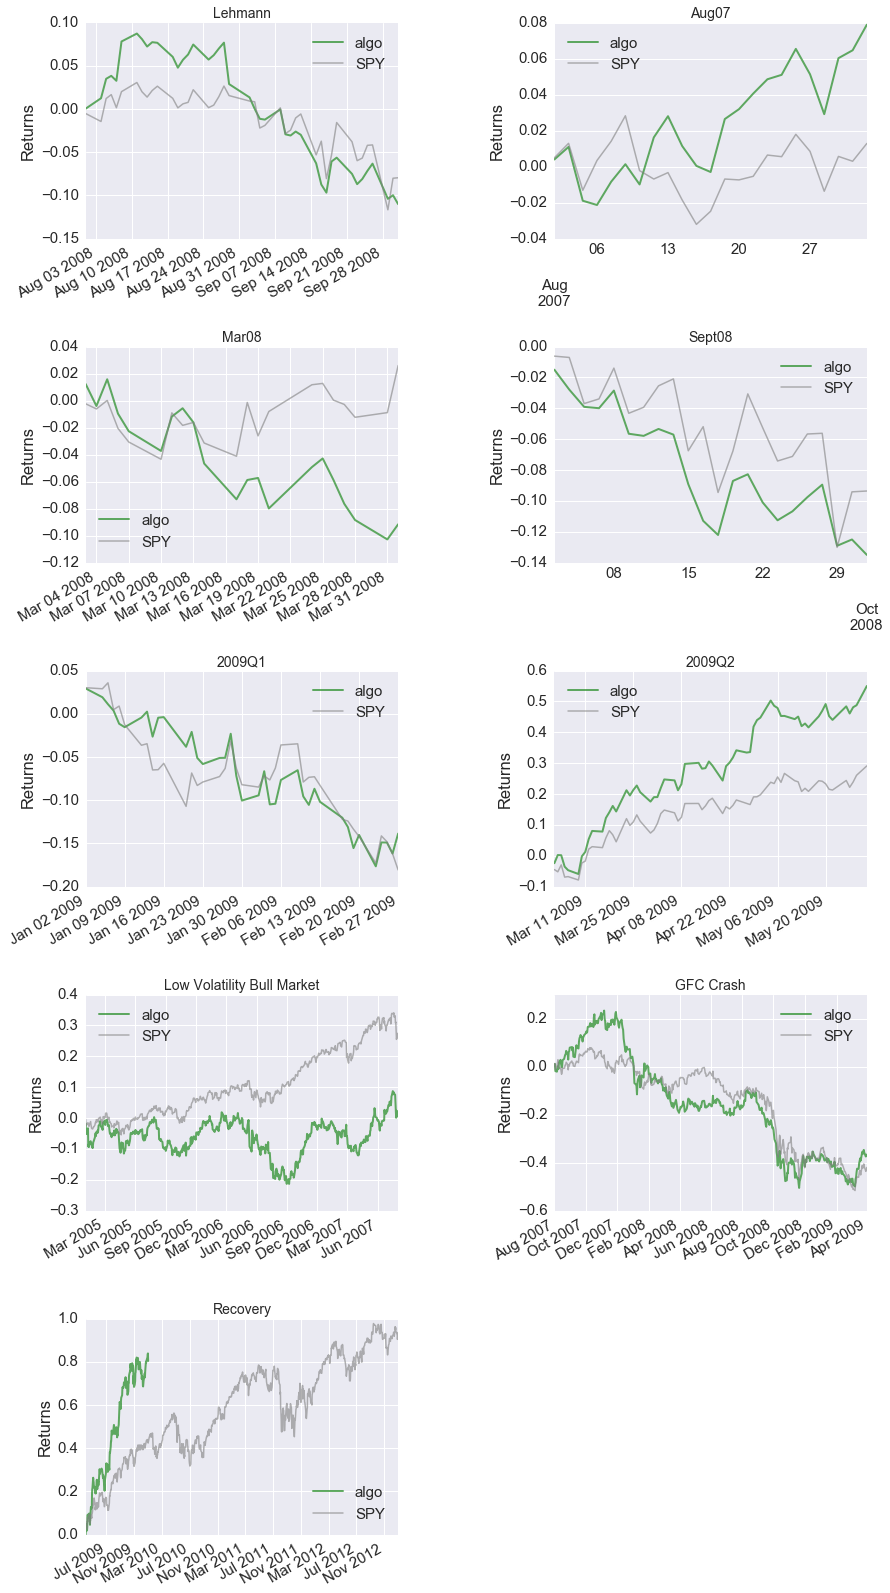

Top 10 long positions of all time,max
sid,
Equity(3 [COST]),100.76%
Equity(7 [MMM]),92.38%
Equity(2 [CERN]),84.49%
Equity(4 [DELL]),71.71%
Equity(1 [AMD]),71.05%
Equity(6 [INTC]),66.55%
Equity(5 [GPS]),62.13%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
Equity(3 [COST]),100.76%
Equity(7 [MMM]),92.38%
Equity(2 [CERN]),84.49%
Equity(4 [DELL]),71.71%
Equity(1 [AMD]),71.05%
Equity(6 [INTC]),66.55%
Equity(5 [GPS]),62.13%


All positions ever held,max
sid,
Equity(3 [COST]),100.76%
Equity(7 [MMM]),92.38%
Equity(2 [CERN]),84.49%
Equity(4 [DELL]),71.71%
Equity(1 [AMD]),71.05%
Equity(6 [INTC]),66.55%
Equity(5 [GPS]),62.13%


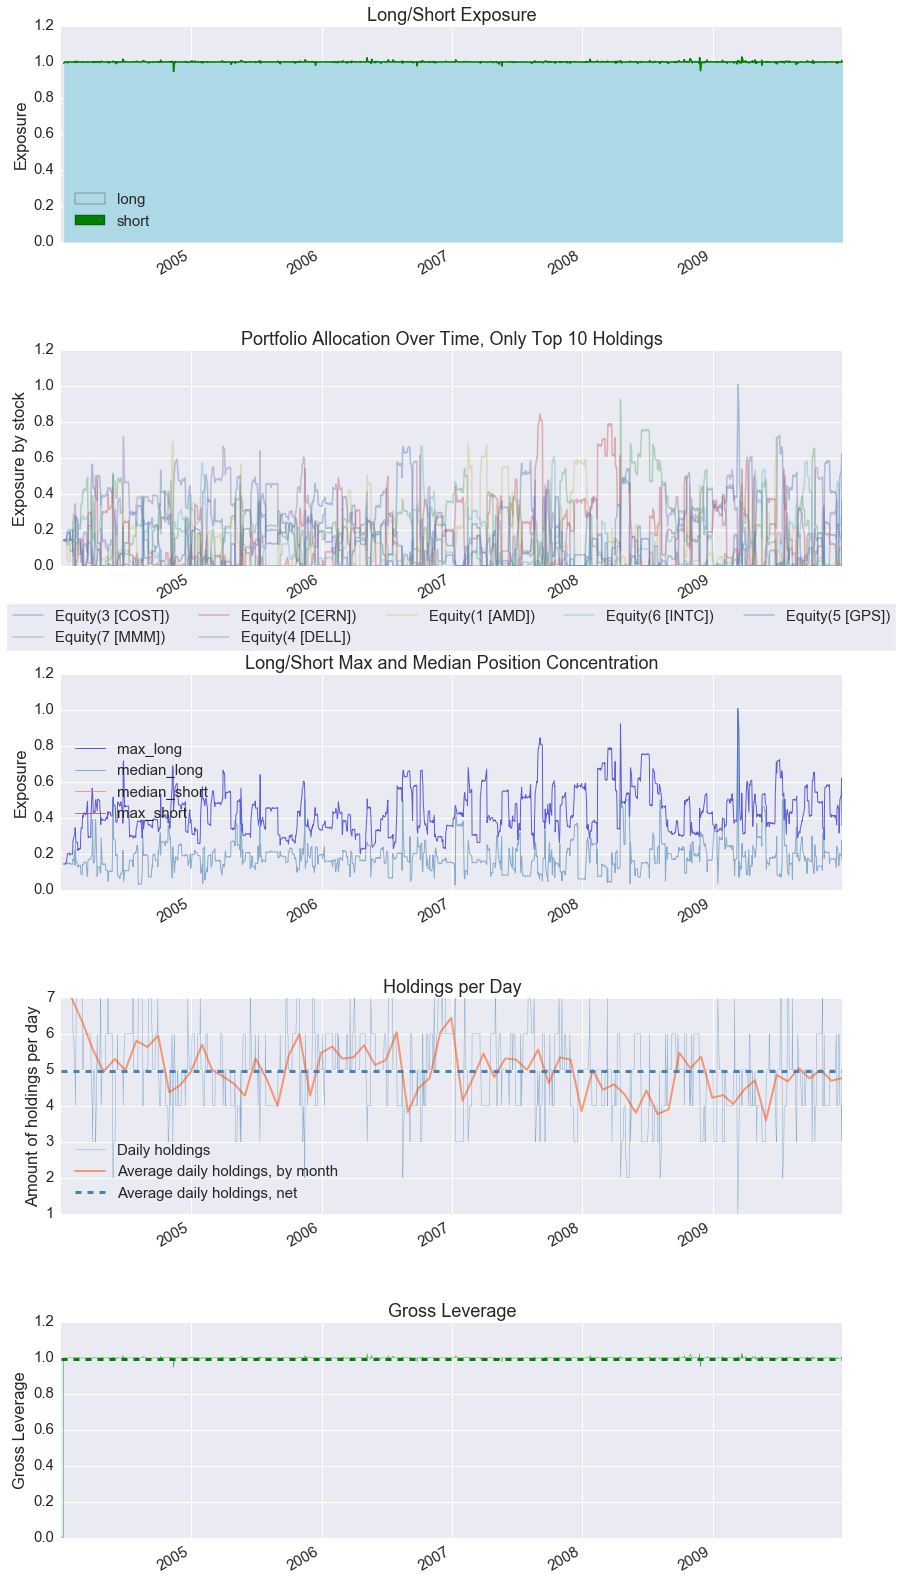

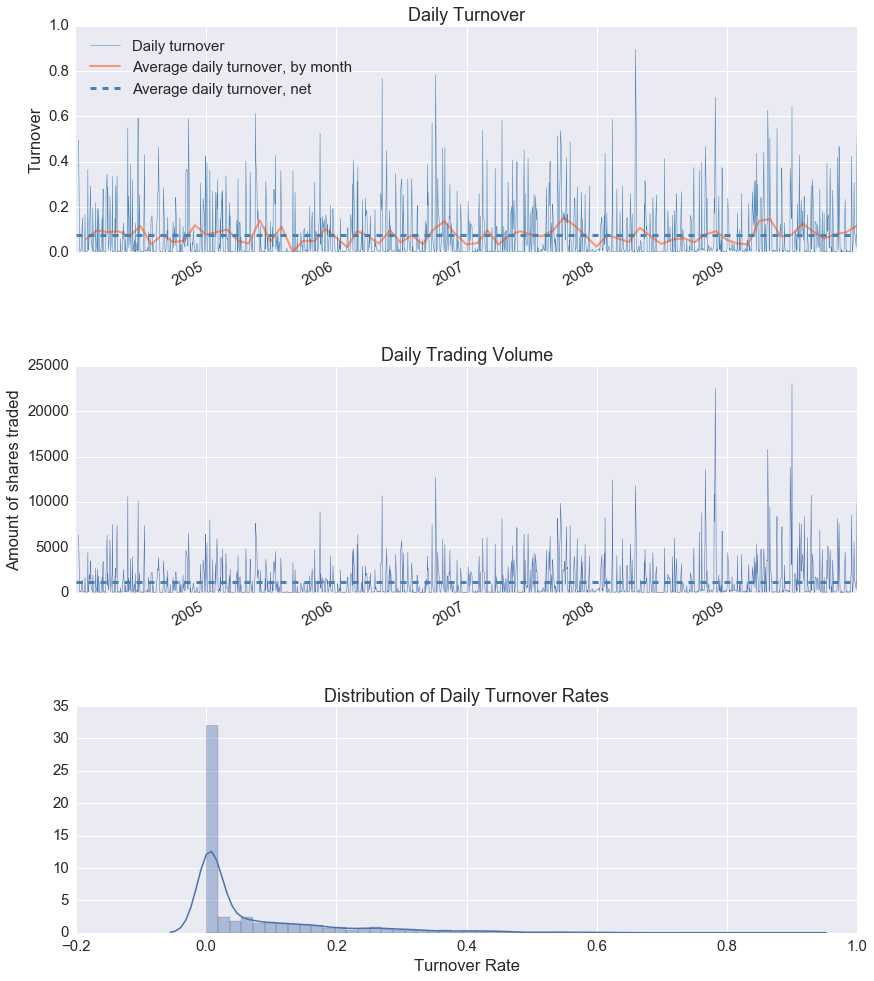

Summary stats,All trades,Long trades
Total number of round_trips,3729.00,3729.00
Percent profitable,0.43,0.43
Winning round_trips,1616.00,1616.00
Losing round_trips,2113.00,2113.00
Even round_trips,0.00,0.00


PnL stats,All trades,Long trades
Total profit,$61673.54,$61673.54
Gross profit,$376899.39,$376899.39
Gross loss,$-315225.85,$-315225.85
Profit factor,$1.20,$1.20
Avg. trade net profit,$16.54,$16.54
Avg. winning trade,$233.23,$233.23
Avg. losing trade,$-149.18,$-149.18
Ratio Avg. Win:Avg. Loss,$1.56,$1.56
Largest winning trade,$15541.78,$15541.78
Largest losing trade,$-12468.25,$-12468.25


Duration stats,All trades,Long trades
Avg duration,22 days 05:36:44.023330,22 days 05:36:44.023330
Median duration,18 days 00:00:00,18 days 00:00:00
Avg # round_trips per day,34.53,34.53
Avg # round_trips per month,725.08,725.08


Return stats,All trades,Long trades
Avg returns all round_trips,0.01%,0.01%
Avg returns winning,0.19%,0.19%
Avg returns losing,-0.13%,-0.13%
Median returns all round_trips,-0.00%,-0.00%
Median returns winning,0.03%,0.03%
Median returns losing,-0.01%,-0.01%
Largest winning trade,12.12%,12.12%
Largest losing trade,-9.15%,-9.15%


Symbol stats,Equity(1 [AMD]),Equity(2 [CERN]),Equity(3 [COST]),Equity(4 [DELL]),Equity(5 [GPS]),Equity(6 [INTC]),Equity(7 [MMM])
Avg returns all round_trips,-0.00%,0.03%,0.03%,-0.04%,-0.01%,0.04%,0.01%
Avg returns winning,0.41%,0.22%,0.15%,0.15%,0.15%,0.19%,0.12%
Avg returns losing,-0.34%,-0.15%,-0.06%,-0.18%,-0.10%,-0.07%,-0.08%
Median returns all round_trips,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%
Median returns winning,0.10%,0.03%,0.03%,0.02%,0.04%,0.06%,0.02%
Median returns losing,-0.02%,-0.01%,-0.01%,-0.01%,-0.01%,-0.00%,-0.01%
Largest winning trade,12.12%,5.91%,2.95%,2.48%,3.52%,2.32%,2.23%
Largest losing trade,-9.15%,-4.68%,-3.41%,-5.87%,-8.27%,-4.61%,-3.84%


Profitability (PnL / PnL total) per name,pnl
symbol,
Equity(6 [INTC]),0.44%
Equity(3 [COST]),0.40%
Equity(2 [CERN]),0.34%
Equity(7 [MMM]),0.18%
Equity(5 [GPS]),0.02%
Equity(1 [AMD]),-0.06%
Equity(4 [DELL]),-0.32%


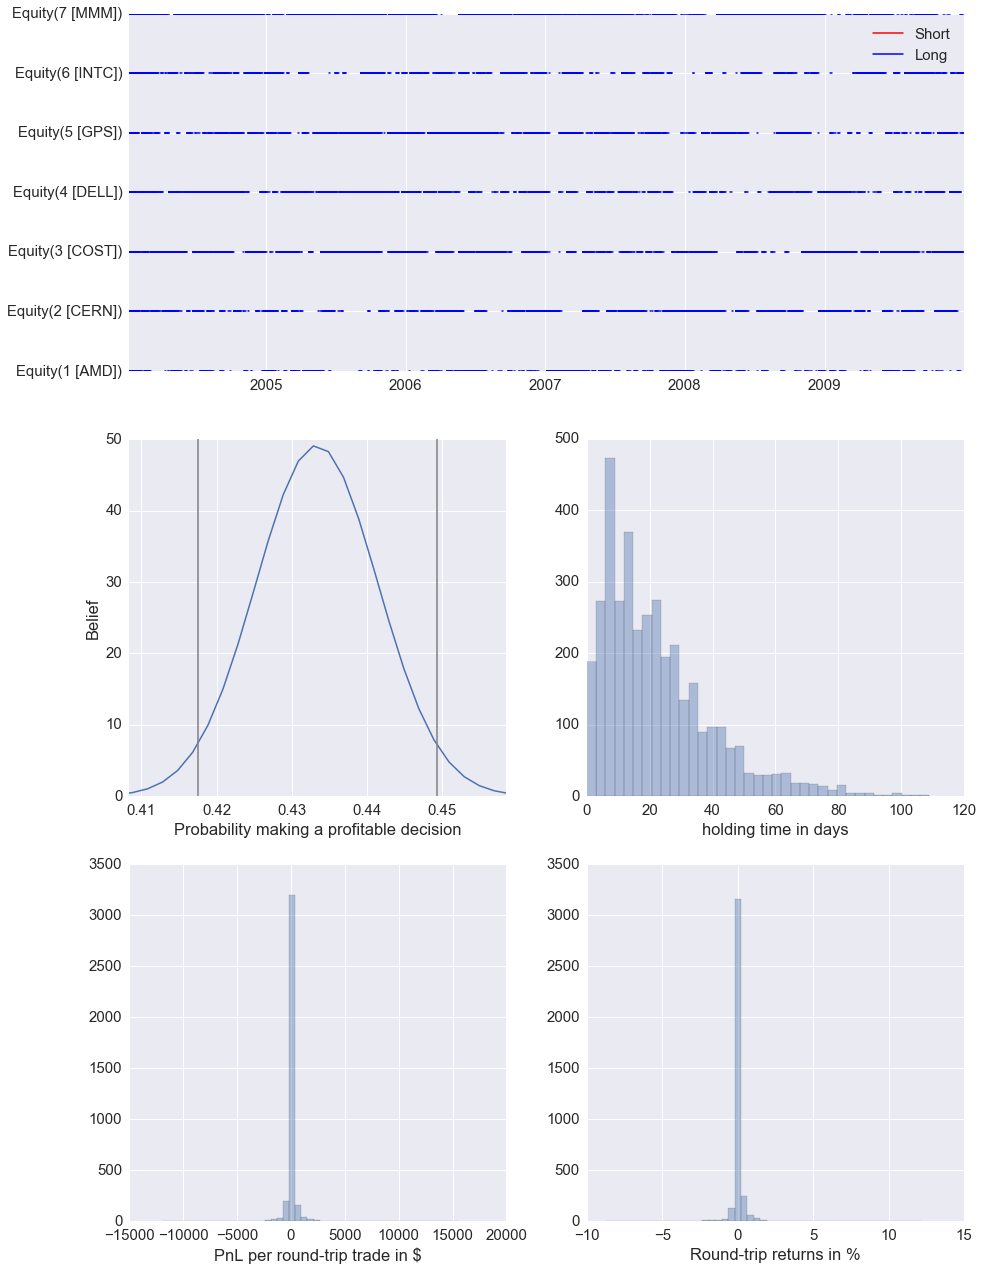

In [6]:
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions,
                          gross_lev=gross_lev, live_start_date='2009-10-22', round_trips=True)

## Suppressing symbol output

When sharing tear sheets it might be undesirable to display which symbols where used by a strategy. To suppress these in the tear sheet you can pass `hide_positions=True`.

Entire data start date: 2004-01-02
Entire data end date: 2009-12-31


Out-of-Sample Months: 2
Backtest Months: 69


Performance statistics,All history,Backtest,Out of sample
annual_return,0.08,0.08,0.03
annual_volatility,0.25,0.26,0.22
sharpe_ratio,0.44,0.43,0.25
calmar_ratio,0.14,0.14,0.42
stability_of_timeseries,-0.01,-0.09,0.22
max_drawdown,-0.60,-0.60,-0.07
omega_ratio,1.08,1.08,1.04
sortino_ratio,0.65,0.64,0.34
skew,0.27,0.28,-0.28
kurtosis,4.05,4.10,0.47


Worst Drawdown Periods,net drawdown in %,peak date,valley date,recovery date,duration
0,59.91,2007-11-06,2008-11-20,NaT,NaN
1,22.79,2006-02-16,2006-08-31,2007-05-22,329
2,12.70,2005-07-28,2005-10-12,2006-01-11,120
3,11.65,2004-11-15,2005-04-28,2005-07-28,184
4,9.50,2007-07-16,2007-08-06,2007-09-13,44




[-0.032 -0.069]


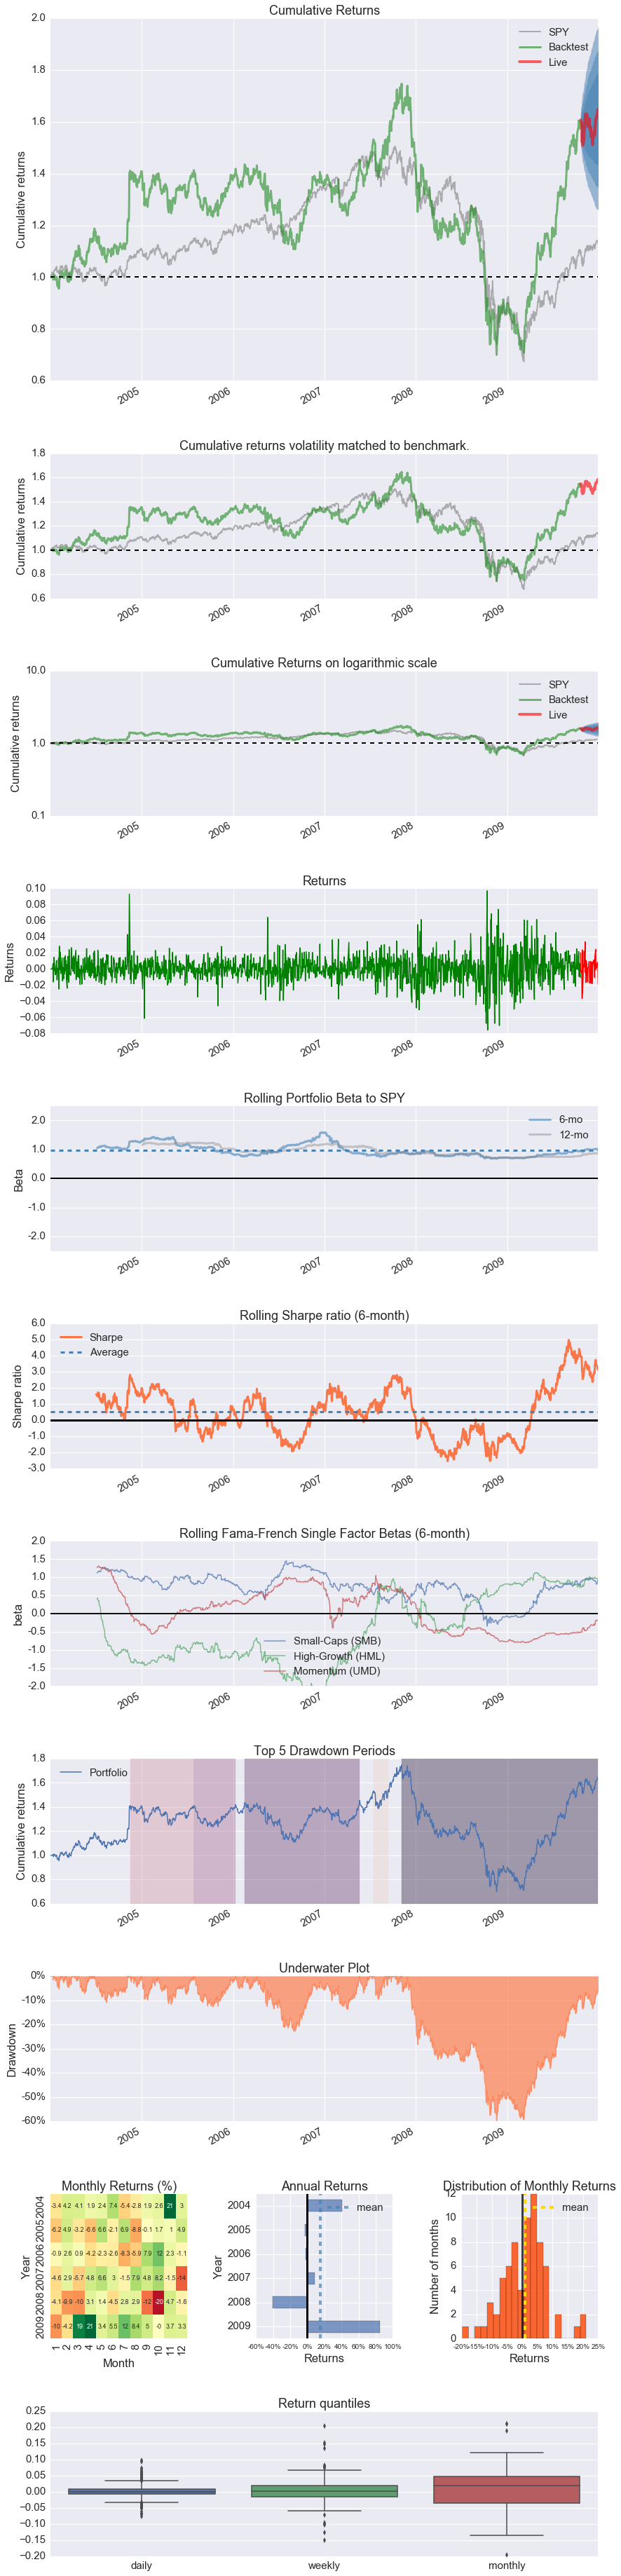

Stress Events,mean,min,max
Lehmann,-0.26%,-4.45%,4.41%
Aug07,0.34%,-2.96%,3.02%
Mar08,-0.44%,-3.10%,3.33%
Sept08,-0.64%,-4.35%,3.99%
2009Q1,-0.36%,-4.99%,3.35%
2009Q2,0.71%,-3.78%,6.15%
Low Volatility Bull Market,0.01%,-6.13%,6.40%
GFC Crash,-0.08%,-7.59%,9.70%
Recovery,0.32%,-3.78%,6.15%


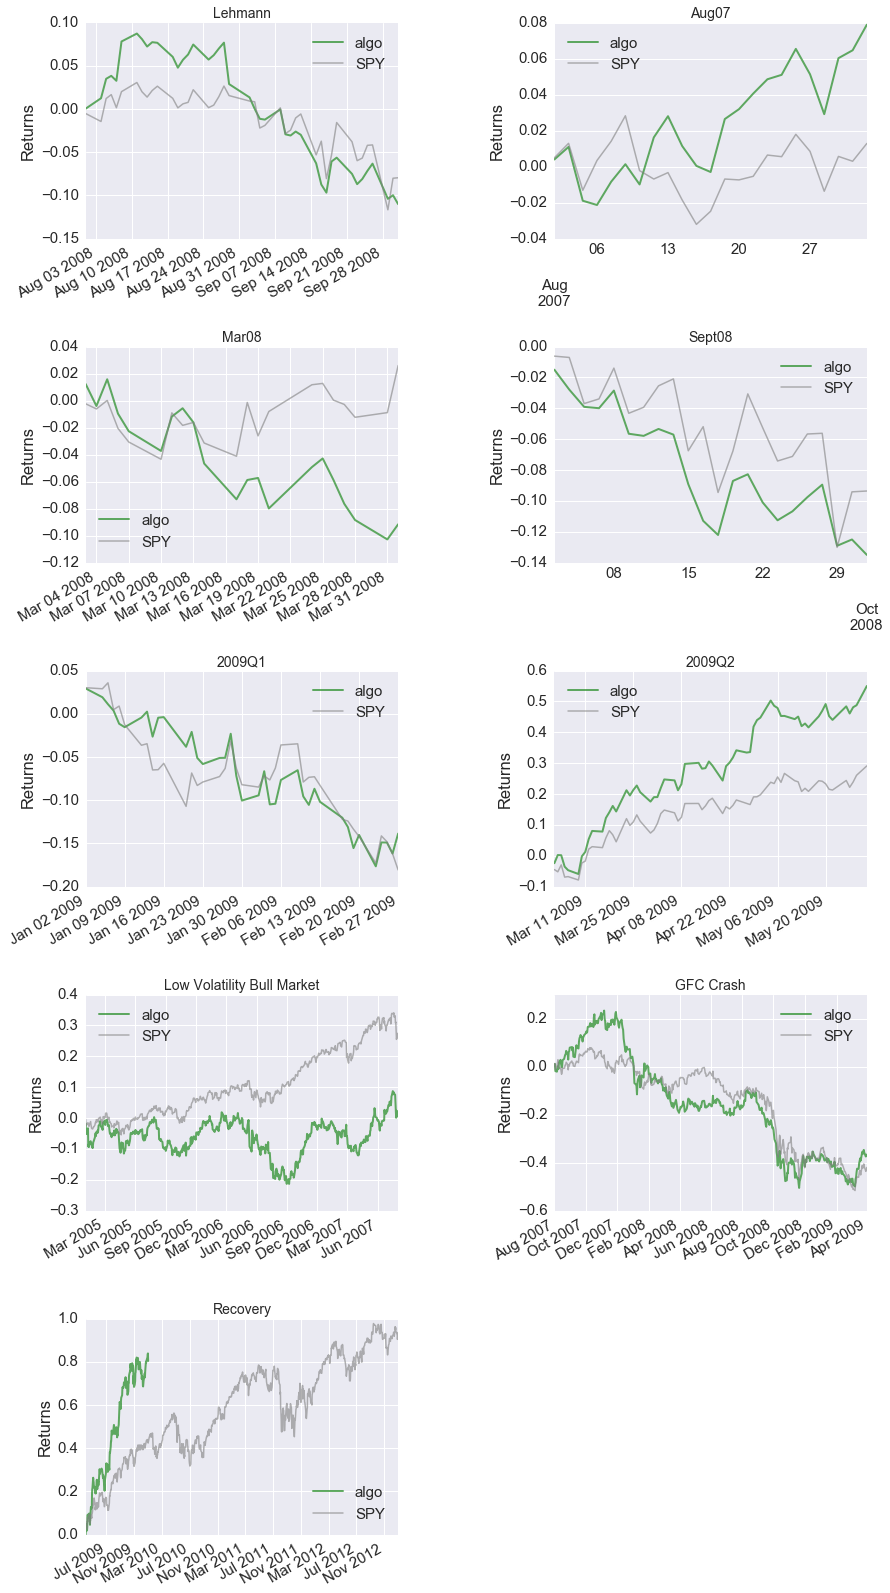

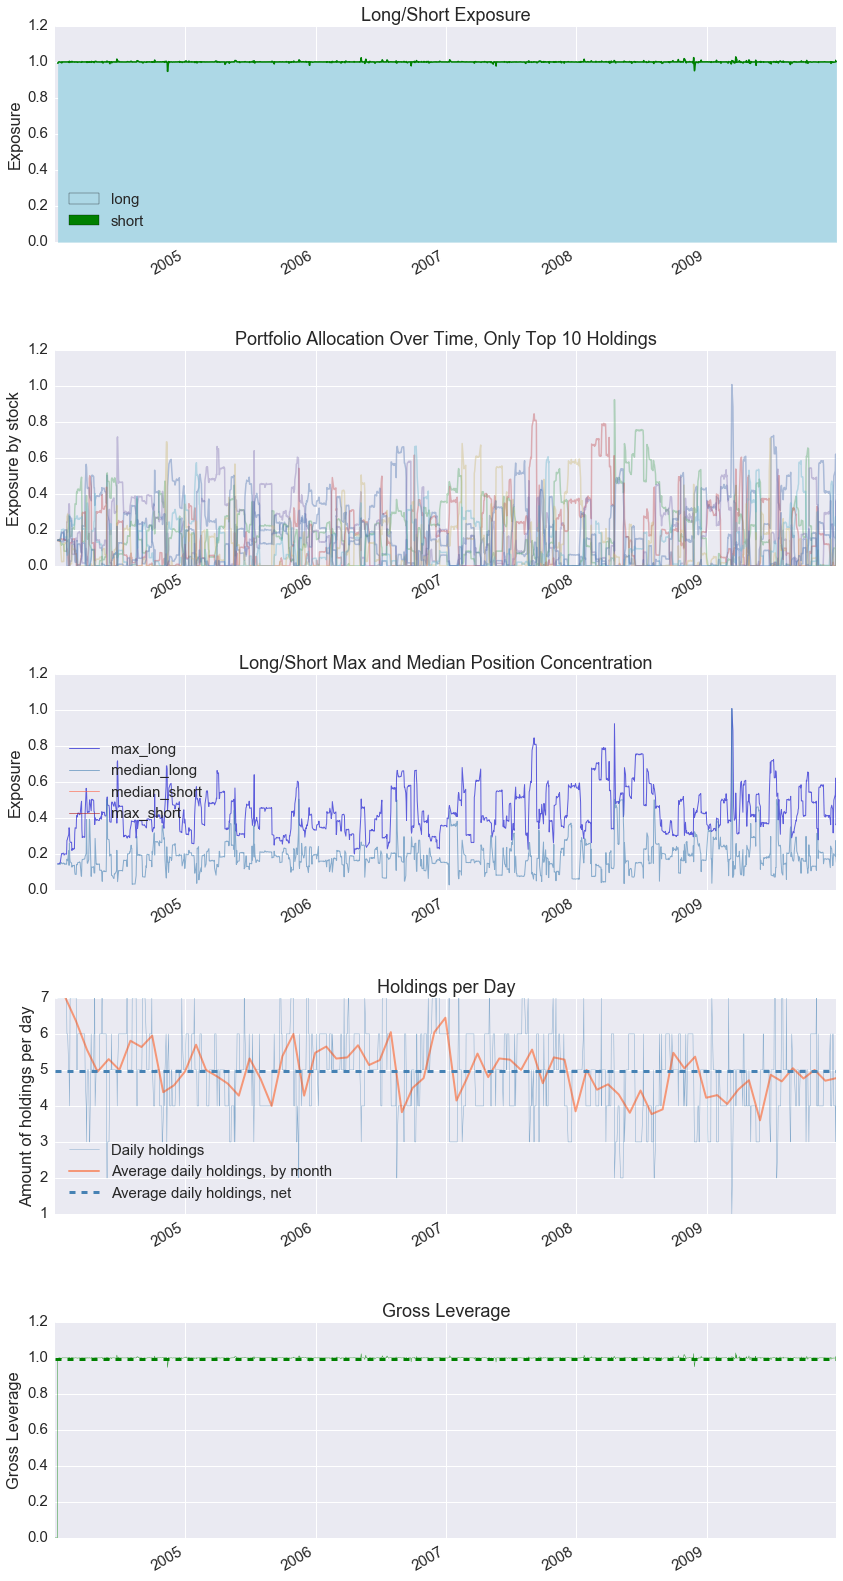

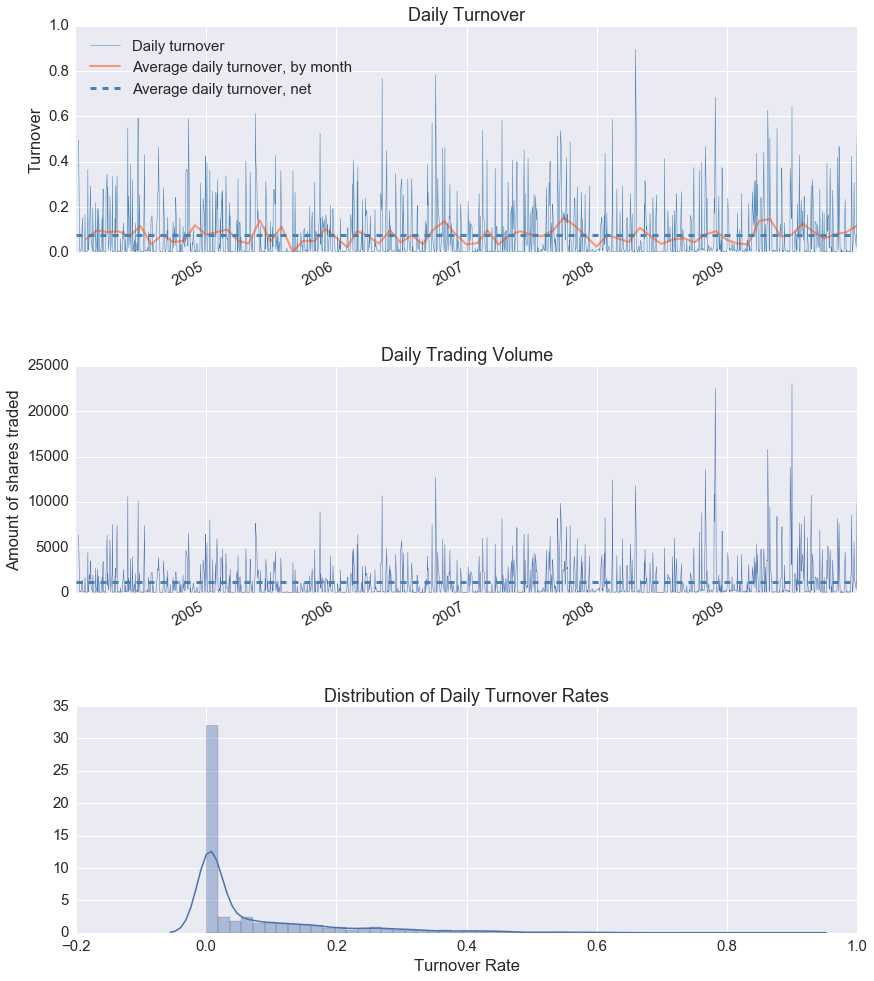

In [7]:
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions,
                          gross_lev=gross_lev, live_start_date='2009-10-22',
                          hide_positions=True)